# From conventional to neural potentials

Brian DeCost, NIST

This tutorial introduces graph neural network models for atomistic properties by building up from conventional classical interatomic potentials.

## learning goals
- review basic pairwise interatomic potentials (Lennard Jones in particular)
- implement pair potential in pytorch (with dgl) with autograd forces
- develop a rough intuition for how neural networks model 1d functions
- replace the polynomials from the LJ model with a neural network layer to obtain a simple graph convolution network

In [1]:
# # execute if running in colab: install notebook dependencies
# # dgl requires torch<=2.4
# !pip install "torch==2.4" ase matplotlib
# !pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html

In [2]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import ase
import ase.neighborlist    
from ase.build import fcc111
from ase.visualize.plot import plot_atoms

import torch
import torch.nn.functional as F

import dgl
import dgl.function as fn

# Interatomic potentials

Interatomic potentials model the energy of a system of atoms as a function of the atomic species and coordinates (see [arxiv:2204.09563](https://arxiv.org/abs/2204.09563) for a comprehensive overview).



Classical potentials expand the total energy $U(\{\mathbf{r}\})$ into additive contributions for pairs, triplets, and higher order cliques of atoms:

$$
U(\{\mathbf{r}\}) = \sum_i \phi_1(\mathbf{r}_i)  
+ \sum_i \sum_j \phi_2(\mathbf{r}_i, \mathbf{r}_j) 
+ \sum_i \sum_j \sum_k \phi_3(\mathbf{r}_i, \mathbf{r}_j, \mathbf{r}_k)
+ \ldots
$$

where $\{\mathbf{r}\}$ is the set of all atomic coordinates $\mathbf{r}_i$, and $\phi_1$, $\phi_2$, $\phi_3$, etc are unary, pair, and triplet interaction functions. (In general, these functions are also species-dependent, but we'll ignore that to keep the notation simple.)

In classical interatomic potentials, the functions $\phi$ are generally based on a physically-motivated functional form, while in machine learning (ML) potentials they are implemented by neural networks, Gaussian processes, or other flexible models for function approximation.

Let's start with a simple pair potential and build up our understanding!


## Pair potentials: Lennard Jones

Let's consider the interatomic interactions between two neon atoms:

$$
\begin{align}
\phi_{LJ}(r) &= 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
\end{align}
$$

where $r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$ is the bond length between atoms $i$ and $j$.

In [3]:
# Lennard Jones energy

@dataclass
class LJParams:
    sigma: float
    epsilon: float

# from  https://doi.org/10.1103/PhysRev.165.951
# Neon: sigma = 2.67 AA, epsilon = 37.1 K
# Argon: sigma = 3.407 AA, epsilon = 119.5 K

kB = 8.617e-5 # eV/K
neon = LJParams(sigma=2.67, epsilon=37.1 * kB)
argon = LJParams(sigma=3.407, epsilon=119.5 * kB)

def lj_energy(r, sigma: float = neon.sigma, epsilon: float = neon.epsilon, parts: bool = False):
    """Lennard Jones pair interaction."""    
    c6 = (sigma / r) ** 6
    c12 = c6 ** 2
    
    if parts:
        return 4 * epsilon * c12, -4 * epsilon * c6
    
    return 4 * epsilon * (c12 - c6)


The force associate with this potential is the negative gradient of the energy with respect to the bond length:

$$
\begin{align}
\frac{\partial\phi_{LJ}}{\partial r} &= 4\epsilon \left[ 12\left(\frac{\sigma}{r}\right)^{13} - 6\left(\frac{\sigma}{r}\right)^7 \right] \\
 &= 24\epsilon \left[ 2\left(\frac{\sigma}{r}\right)^{13} - \left(\frac{\sigma}{r}\right)^7 \right]
\end{align}
$$

where $r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$ is the bond length between atoms $i$ and $j$.

In [4]:
# Lennard Jones force
def lj_force(r, sigma: float = 2.67, epsilon: float = 37.1 * kB, parts: bool = False):
    """Lennard Jones pair force."""    
    c6 = (sigma / r) ** 6
    c12 = c6 ** 2
    
    if parts:
        return 4 * 12 * epsilon * c12 / r, -4 * 6 * epsilon * c6 / r
    
    return 4 * 12 * epsilon * (c12/r - 0.5 * c6/r)

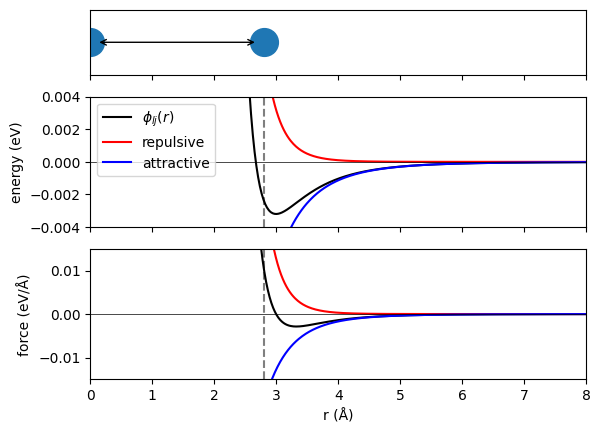

In [5]:
# draw a diatomic molecule at separation r
r = 2.8

fig, axes = plt.subplots(nrows=3, height_ratios=[0.2, 0.4, 0.4], sharex=True)

axes[0].scatter([0, r], [0, 0], s=400)
axes[0].annotate("", xytext=(0.1, 0), xy=(r - 0.1, 0), arrowprops=dict(arrowstyle="<->", color="k"),)
axes[0].set_yticks([])

rs = np.linspace(0.9, 8, 500)

axes[1].plot(rs, lj_energy(rs), color="k", label=r"$\phi_{lj}(r)$");
vr, va = lj_energy(rs, parts=True)
axes[1].plot(rs, vr, color="r", label="repulsive")
axes[1].plot(rs, va, color="b", label="attractive")
axes[1].legend();

axes[2].plot(rs, lj_force(rs), color="k", label=r"$\phi_{lj}(r)$");
vr, va = lj_force(rs, parts=True)
axes[2].plot(rs, vr, color="r", label="repulsive")
axes[2].plot(rs, va, color="b", label="attractive")
axes[2].set_ylim(-1.5e-2, 1.5e-2)
axes[2].axhline(0, color="k", linewidth=0.5);
axes[2].axvline(r, color="k", linestyle="--", alpha=0.5);

axes[1].set_ylim(-4e-3, 4e-3)
axes[1].axhline(0, color="k", linewidth=0.5);
axes[1].axvline(r, color="k", linestyle="--", alpha=0.5);
plt.xlim(0, rs.max());

plt.xlabel("r (Å)")
axes[1].set_ylabel("energy (eV)");
axes[2].set_ylabel("force (eV/Å)");

The total energy for a collection of atoms sums up the contribution from each pair of atoms in the system:

$$
\begin{align}
U(\{\mathbf{r}\}) &= \sum_i \sum_j \phi_{LJ}(r_{ij}) \\
\end{align}
$$

Typically the pair interactions are truncated with a radial cutoff function that limits computational cost (and sometimes can be used to sort of account for screening effects)

This is typically implemented by iterating over a neighbor list:

```python

energy = 0.0
for i in range(len(atoms)):
    for j in neighbors(atoms, i):
        distance = norm(atoms.positions[j] - atoms.positions[i])
        energy += lj_energy(distance)
```

In [6]:
atoms = ase.build.fcc111('Ne', size=(5,5,1), vacuum=10.0)

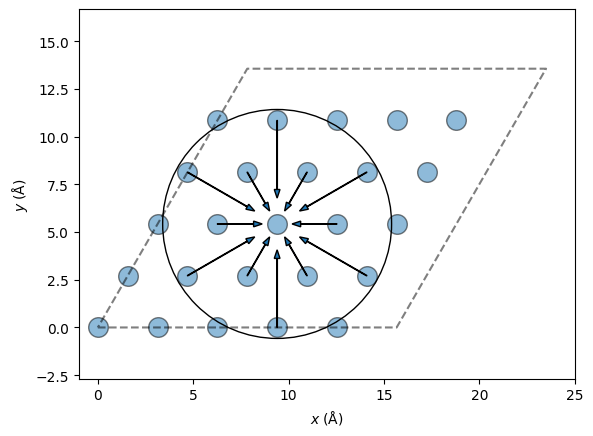

In [7]:
def draw_cell(atoms, ax):
    """Draw cell oriented along [0 0 1] direction."""
    corners = np.stack([
        (atoms.get_scaled_positions()[0] + offset @ atoms.cell.array)[:2]
        for offset in [[0,0,0], [1,0,0], [1, 1, 0], [0,1,0], [0,0,0]]
    ])
    ax.plot(corners[:,0], corners[:,1], linestyle="--", color="k", alpha=0.5)
    ax.set_xlabel(r"$x\;(\mathrm{\AA})$")
    ax.set_ylabel(r"$y\;(\mathrm{\AA})$");
    return


r1, r2, r3 = atoms.get_positions().T

fig, ax = plt.subplots()
plt.scatter(r1, r2, s=200, edgecolors="k", alpha=0.5)
draw_cell(atoms, ax)

ax.axis("equal")
ax.set(xlim=(-1, 25), ylim=(-1, 15));

i = 12

fcut = plt.Circle((r1[i], r2[i]), 6, edgecolor="k", facecolor="none")
ax.add_patch(fcut)


nbrs = [7, 8, 11, 13, 16, 17]
nbrs += [3, 6, 9, 15, 18, 21]
f = 0.75
for nbr in nbrs:
    ax.arrow(
        r1[nbr], r2[nbr], f*(r1[i]-r1[nbr]), f*(r2[i]-r2[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True
    )


### implementing Lennard Jones in dgl
Implementing Lennard Jones in pytorch/dgl is straightforward, and it will give us a nice first look at graph computation.


In dgl, [graphs](https://docs.dgl.ai/api/python/dgl.DGLGraph.html) have a `dict`-like interface for storing node and edge attributes (`DGLGraph.ndata` and `DGLGraph.edata`), so we can store the atomic positions $\mathbf{r}_{i}$ as node attributes:

In [8]:
import dgl
import dgl.function as fn
import ase.neighborlist     

def radius_graph(atoms: ase.Atoms, cutoff: float = 6.0) -> dgl.DGLGraph:
    """Construct fixed-cutoff radius DGL neighbor list from ase.Atoms."""

    # get neighbor ids, relative position vectors to construct graph (i.e. neighbor list)
    # D: positions[j] - positions[i] + S.dot(atoms.cell)
    i, j, r_ij = ase.neighborlist.neighbor_list("ijD", atoms, cutoff)
    g = dgl.graph((i, j), num_nodes=len(atoms))

    # store atomic numbers and cartesian coordinates as node attributes
    # cast to default torch floating point type
    dtype = torch.get_default_dtype()
    g.ndata["numbers"] = torch.asarray(atoms.numbers)
    g.ndata["positions"] = torch.asarray(atoms.positions).type(dtype)

    # store relative positions as edge attributes
    g.edata["r_ij"] = torch.asarray(r_ij).type(dtype)

    return g

g = radius_graph(atoms)
g

Graph(num_nodes=25, num_edges=300,
      ndata_schemes={'numbers': Scheme(shape=(), dtype=torch.int64), 'positions': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'r_ij': Scheme(shape=(3,), dtype=torch.float32)})

dgl provides a [message-passing](https://docs.dgl.ai/guide/message.html) interface for expressing graph-based computation.
We can express the Lennard Jones potential with a `message` function `lj_kernel` that computes the bond length and then the pair potential, returning a dictionary of new edge attributes.

In [9]:
def lj_kernel(edges):
    """compute relative position vector -> bond length"""
    r_ij = edges.data["r_ij"]
    distances = r_ij.norm(dim=1)
    
    return {"phi_ij": 0.5 * lj_energy(distances)}

g.update_all(lj_kernel, fn.sum("phi_ij", "energy_i"))
g.ndata["energy_i"]

/Users/bld/.pyenv/versions/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


tensor([-0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096, -0.0096,
        -0.0096])

In [10]:
g.ndata["energy_i"].sum()

tensor(-0.2402)

In a conventional molecular dynamics code, this would be implemented with `for` loops over a neighbor list. In DGL, it's implemented with sparse matrix multiplication and PyTorch tensor broadcasting.

Advantages:

- simplicity of implementation (no C++ / CUDA in user code)
- portable code (CPU/GPU) with reasonably good performance
- automatic differentiation!

Disadvantages:
- higher memory cost
- slower than LAMMPS (for now?)

In [11]:
import ase.calculators
import ase.calculators.lj

lj_exact = ase.calculators.lj.LennardJones(sigma=neon.sigma, epsilon=neon.epsilon, rc=6.0)
atoms.calc = lj_exact
atoms.get_total_energy()

-0.2253939100867252

This small discrepancy is because ase shifts the potential so its value at the cutoff radius is zero:

In [12]:
lj_energy(6)

-9.852908652169324e-05

adding up this energy offset for every entry in the neighbor list (dividing by two to account for double counting):

In [13]:
lj_energy(6) * g.num_edges() / 2

-0.014779362978253987

this is equal to the difference in energy from our DGL pair potential and the ase Lennard Jones potential:

In [14]:
g.ndata["energy_i"].sum() - atoms.get_total_energy()

tensor(-0.0148)

### autograd forces

We can compute the atomic forces $-\frac{\partial U}{\partial\mathbf{r}_i}$ using the pytorch autograd system, as long as we take care to ensure that the atomic positions $\{\mathbf{r}_i\}$ are included in the autograd graph before executing the model:

In [15]:
# shake things up to get nonzero atomic forces:
atoms.rattle(stdev=[0.1, 0.1, 0.0])

In [16]:
# re-build the neighbor list and enable gradient tracking for relative displacement vectors:
g = radius_graph(atoms)
g.edata["r_ij"].requires_grad_(True)

# re-evaluate the total energy:
g.update_all(lj_kernel, fn.sum("phi_ij", "energy_i"))
total_energy = g.ndata["energy_i"].sum()

# calculate (negative) gradient wrt displacement vectors:
pair_forces = -torch.autograd.grad(total_energy, g.edata["r_ij"])[0]
pair_forces[:10]


tensor([[ 1.2108e-03,  6.8054e-05, -0.0000e+00],
        [ 1.1269e-06, -9.9542e-05, -0.0000e+00],
        [-1.0749e-04, -6.0970e-05, -0.0000e+00],
        [-4.3746e-05, -7.8645e-05, -0.0000e+00],
        [ 4.6832e-04, -7.9121e-04, -0.0000e+00],
        [ 7.4570e-05, -4.2506e-05, -0.0000e+00],
        [ 6.6964e-04,  1.0937e-03, -0.0000e+00],
        [-1.3789e-03,  4.0870e-06, -0.0000e+00],
        [ 2.1845e-07,  7.9737e-05, -0.0000e+00],
        [ 1.9986e-04, -3.7452e-04,  0.0000e+00]])

Finally, use another message passing step to sum the pair forces:

In [17]:
# store pair forces as an edge attribute
g.edata["pair_forces"] = pair_forces

# sum forces over neighbors
g.update_all(fn.copy_e("pair_forces", "m"), fn.sum("m", "forces"))

# also sum reaction forces over reversed neighbor list:
rg = dgl.reverse(g, copy_edata=True)
rg.update_all(fn.copy_e("pair_forces", "m"), fn.sum("m", "forces"))

# obtain atomic forces:
forces = g.ndata["forces"] - rg.ndata["forces"]
forces[:10]

tensor([[-2.1741e-03,  1.9820e-04,  0.0000e+00],
        [-5.3458e-03, -1.2215e-03,  0.0000e+00],
        [-3.2414e-03, -2.3895e-03,  0.0000e+00],
        [-1.4932e-03,  4.3285e-03,  0.0000e+00],
        [ 3.2721e-03,  1.1564e-02,  0.0000e+00],
        [ 2.3081e-03,  2.3759e-03,  0.0000e+00],
        [ 3.1263e-03,  6.3191e-03,  0.0000e+00],
        [-9.2107e-04, -7.7947e-05,  0.0000e+00],
        [ 4.0142e-03, -4.5720e-03,  0.0000e+00],
        [-2.5693e-03,  3.7196e-04,  0.0000e+00]])

The autograd forces are equal to the analytic forces:

In [18]:
print(f"all forces match? {np.isclose(forces, atoms.get_forces()).all()}")

atoms.get_forces()[:10]

all forces match? True


array([[-2.17408293e-03,  1.98200433e-04,  0.00000000e+00],
       [-5.34578566e-03, -1.22144928e-03,  0.00000000e+00],
       [-3.24136252e-03, -2.38953224e-03,  0.00000000e+00],
       [-1.49318309e-03,  4.32847869e-03,  0.00000000e+00],
       [ 3.27211810e-03,  1.15642220e-02,  0.00000000e+00],
       [ 2.30809034e-03,  2.37593364e-03,  0.00000000e+00],
       [ 3.12625689e-03,  6.31908854e-03,  0.00000000e+00],
       [-9.21071738e-04, -7.79567526e-05,  0.00000000e+00],
       [ 4.01419487e-03, -4.57201480e-03,  0.00000000e+00],
       [-2.56928266e-03,  3.71957498e-04,  0.00000000e+00]])

### Multicomponent systems

Multicomponent potentials typically have explicit cross-species parameters.
For example, a Lennard Jones style potential for a binary mixture of Ne and Ar could have three sets of $\sigma$ and $\epsilon$ parameters:


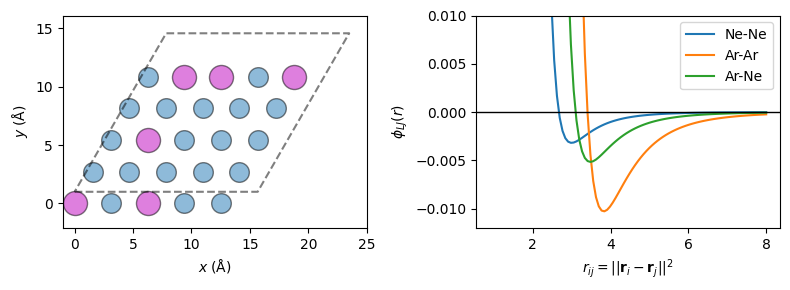

In [19]:
# we'll use fake indices instead of atomic numbers to simplify storing model parameters...
z = np.random.choice([0, 1], len(atoms), p=[0.7, 0.3])
atoms.set_atomic_numbers(z)

fig, axes = plt.subplots(ncols=2, figsize=(8,3))
ax = axes[0]
ax.scatter(r1[z == 0], r2[z == 0], s=200, edgecolors="k", alpha=0.5)
ax.scatter(r1[z != 0], r2[z != 0], s=300, edgecolors="k", alpha=0.5, color="m")
draw_cell(atoms, ax)

ax.axis("equal")
ax.set(xlim=(-1, 25), ylim=(-1, 15));

ax = axes[1]
rs = np.linspace(.9, 8.0, 100)
ax.plot(rs, lj_energy(rs), label="Ne-Ne")
ax.plot(rs, lj_energy(rs, sigma=argon.sigma, epsilon=argon.epsilon), label="Ar-Ar")
ax.plot(rs, lj_energy(rs, sigma=3.1, epsilon=60.0 * kB), label="Ar-Ne")
ax.axhline(0, color="k", linewidth=1)
ax.set(xlabel=r"$r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$", ylabel=r"$\phi_{LJ}(r)$")
ax.set_ylim(-1.2e-2, 1e-2)
plt.legend();
plt.tight_layout()

We could implement this model by adding the atomic numbers as additional edge attributes and modifying our Lennard Jones edge message to look up the parameters for each bond type.

In this case, the pair potential function will be something like $\phi_2(\mathbf{r}_i, \mathbf{r}_j, h_i, h_j)$

In [20]:
g = radius_graph(atoms)
g.ndata["numbers"]

tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1])

In [21]:
from torch import nn

sigmas = [neon.sigma, argon.sigma]
epsilons = [neon.epsilon, argon.epsilon]

sigma = nn.Embedding(2, 1, _weight=torch.asarray(sigmas).unsqueeze(1), _freeze=True)
epsilon = nn.Embedding(2, 1, _weight=torch.asarray(epsilons).unsqueeze(1), _freeze=True)

In [22]:
def binary_lj_kernel(edges):
    """Multicomponent lennard jones interaction."""

    # use arithmetic mean for cross-terms
    sigma_ij = 0.5 * (edges.src["sigma"] + edges.dst["sigma"])
    epsilon_ij = 0.5 * (edges.src["epsilon"] + edges.dst["epsilon"])

    # compute relative position vector -> bond length
    r_ij = edges.data["r_ij"].norm(dim=1, keepdim=True)

    # compute speciated pair interaction
    phi_ij = lj_energy(r_ij, sigma=sigma_ij, epsilon=epsilon_ij)

    return {"phi_ij": phi_ij}

In [23]:
with g.local_scope():
    # store per-atom lennard jones parameters as node features
    g.ndata["sigma"] = sigma(g.ndata["numbers"])
    g.ndata["epsilon"] = epsilon(g.ndata["numbers"])

    # evaluate mixture lennard jones model
    g.update_all(binary_lj_kernel, fn.sum("phi_ij", "energy_i"))
    energy_i = g.ndata["energy_i"]

energy_i.squeeze()

tensor([ 0.0976, -0.0154,  0.0141, -0.0050,  0.0004, -0.0154, -0.0227, -0.0155,
        -0.0210, -0.0181, -0.0181, -0.0223, -0.0232, -0.0193, -0.0197, -0.0178,
        -0.0174, -0.0263, -0.0229, -0.0238, -0.0191,  0.1157,  0.0329, -0.0186,
        -0.0020])

## GNN potentials (or, who needs cross-terms anyway?)
The essence of GNN potentials is very similar to this model:
- replace the polynomial two-body contributions $\phi_2$ with a simple neural network
- use multiple rounds of pairwise interaction!

that's the entire core idea.

GNN variants primarily differ in the form of the neural networks used, the basis functions used to represent atom and bond lengths, and the reduction function.

### atom input representations
We have already seen this concept hiding in the parameterization of the binary Lennard Jones model.
If we drop the cross-interaction term and collect the Lennard Jones parameters into a single lookup table, we get a matrix of "atom features" $\mathbf{h}_i$

In our Lennard Jones example, $\mathbf{h}_i = [\sigma_i, \epsilon_i]$

In [24]:
# make column vectors of LJ parameters:
sigmas = torch.asarray([neon.sigma, argon.sigma]).unsqueeze(1)
epsilons = torch.asarray([neon.epsilon, argon.epsilon]).unsqueeze(1)

# collect atom features (LJ parameters) in a single parameter matrix
H = torch.hstack([sigmas, epsilons])
H

tensor([[2.6700e+00, 3.1969e-03],
        [3.4070e+00, 1.0297e-02]])

In [25]:
embed = torch.nn.Embedding(2, 2, _weight=H, _freeze=True)

print("sigma_i, epsilon_i")
embed(g.ndata["numbers"])

sigma_i, epsilon_i


tensor([[3.4070e+00, 1.0297e-02],
        [2.6700e+00, 3.1969e-03],
        [3.4070e+00, 1.0297e-02],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [3.4070e+00, 1.0297e-02],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [2.6700e+00, 3.1969e-03],
        [3.4070e+00, 1.0297e-02],
        [3.4070e+00, 1.0297e-02],
        [2.6700e+00, 3.1969e-03],
        [3.4070e+00, 1.0297e-02]])

In general, people like to use tabulated physical properties (covalent radii, electronegativities, row, period, atomic number/mass) - or they learn arbitrary atom embeddings from whole cloth (analogous to learnable embeddings for discrete tokens in language models)

Aside: if we stack global average, range, min, max, and standard deviation reductions without any pair interactions, we get Magpie-style composition features!


### Replacing LJ polynomials with neural networks

#### what is a neural network?

Neural networks have an air of mystique, but it's all just function composition with simple building blocks.

The classic feedforward neural network is:

$$\hat{y} = \mathbf{W}_2 \sigma\left(\mathbf{W}_1 \mathbf{h}_0 \right)$$

$\mathbf{h}_0$ is the input, $\mathbf{W}_1$ and $\mathbf{W}_2$ parameter matrices for linear functions, and $\sigma$ is a pointwise nonlinearity like $\sigma(x)  = \frac{1}{1 + e^{-x}}$ or $max(0, x)$


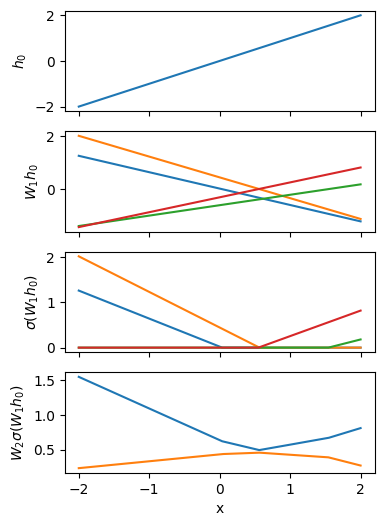

In [26]:
# torch.random.manual_seed(0)

d_in = 1
d_model = 4
d_out = 2

bias_latent = True
bias_out = True

feedforward = torch.nn.Sequential(
    torch.nn.Linear(d_in, d_model, bias=bias_latent),
    # torch.nn.Sigmoid(),
    torch.nn.ReLU(),
    # torch.nn.GELU(),
    torch.nn.Linear(d_model, d_out, bias=bias_out)
)

fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(4, 6))

x = torch.linspace(-2, 2, 500).unsqueeze(1)

labels = ["$h_0$", "$W_1 h_0$", "$\sigma(W_1 h_0)$", "$W_2 \sigma(W_1 h_0)$"]
for layer_id, ax in enumerate(axes):
    with torch.no_grad():
        h = feedforward[:layer_id](x)
    ax.plot(x, h)
    ax.set_ylabel(labels[layer_id])


axes[-1].set_xlabel("x");

The inner linear function projects the input features $\mathbf{h}^0$ into a higher-dimensional intermediate representation $\mathbf{W}_1 \mathbf{h}^0$ 

In [27]:
h_0 = torch.tensor([1.0]).unsqueeze(1)
h_1 = feedforward[0](h_0)
h_1

tensor([[-0.5979, -0.3409, -0.2130,  0.2538]], grad_fn=<AddmmBackward0>)

In [28]:
W_1 = feedforward[0].weight
b_1 = feedforward[0].bias

print(f"{W_1=}, {b_1=}")

W_1=Parameter containing:
tensor([[-0.6183],
        [-0.7841],
        [ 0.3931],
        [ 0.5622]], requires_grad=True), b_1=Parameter containing:
tensor([ 0.0203,  0.4432, -0.6061, -0.3084], requires_grad=True)


writing out the matrix multiplication explicitly:

In [29]:
(W_1 @ h_0).T + b_1


tensor([[-0.5979, -0.3409, -0.2130,  0.2538]], grad_fn=<AddBackward0>)

The pointwise nonlinearity changes the relative importance of intermediate dimensions:

$$\mathbf{h}^1 = \sigma\left( \mathbf{W}_1 \mathbf{h}^0 \right)$$

Note: modern deep learning models often use sigmoid-linear units $silu(x) = x \sigma(x)$, but $relu(x) = max(0, x)$ is also still a popular choice.

 In atomistic modeling, sigmoid-linear activations are more common because its derivative(s) are continuous everywhere.

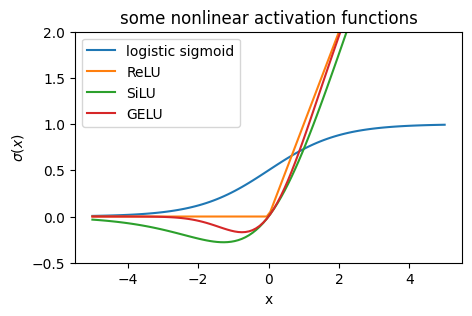

In [30]:
fig, ax = plt.subplots(figsize=(5,3))
xs = torch.linspace(-5, 5, 100)
plt.plot(xs, torch.sigmoid(xs), label="logistic sigmoid")
plt.plot(xs, torch.nn.functional.relu(xs), label="ReLU")
plt.plot(xs, torch.nn.functional.silu(xs), label="SiLU")
plt.plot(xs, torch.nn.functional.gelu(xs), label="GELU")
plt.xlabel("x")
plt.ylabel(r"$\sigma(x)$");
plt.ylim(-0.5, 2)
plt.legend(loc="upper left");
plt.title("some nonlinear activation functions");

In [31]:
feedforward[:2](h_0)

tensor([[0.0000, 0.0000, 0.0000, 0.2538]], grad_fn=<ReluBackward0>)

In [32]:
h_1 = torch.nn.functional.gelu((W_1 @ h_0).T + b_1)

The outer linear function maps the intermediate $\mathbf{h}^1$ to a scalar prediction $\hat{y}$:

$$\hat{y} = \mathbf{W}_2 \mathbf{h}^1$$

In [33]:
feedforward(h_0)

tensor([[0.5720, 0.4266]], grad_fn=<AddmmBackward0>)

In [34]:
W_2 = feedforward[-1].weight
b_2 = feedforward[-1].bias

print(f"{W_2=}, {b_2=}")

W_2=Parameter containing:
tensor([[ 0.3427,  0.3119,  0.3340,  0.3176],
        [-0.0963, -0.0514, -0.4831, -0.1221]], requires_grad=True), b_2=Parameter containing:
tensor([0.4914, 0.4576], requires_grad=True)


In [35]:
(W_1 @ h_0).T + b_1

tensor([[-0.5979, -0.3409, -0.2130,  0.2538]], grad_fn=<AddBackward0>)

In [36]:
# (W_2 @ F.gelu((W_1 @ h_0).T + b_1).T).T + b_2
(W_2 @ h_1.T).T + b_2

tensor([[0.4148, 0.5040]], grad_fn=<AddBackward0>)

The full FFN model $\mathbf{W}_2 \sigma\left(\mathbf{W}_1 \mathbf{h}^0 \right)$ just chains the component functions together. The whole model is just matrix-vector multiplication (linear projections) and pointwise nonlinearity functions:

The model capacity is controlled by the *depth* of the model (the number of intermediate transformations) and the *width* of the model (the dimensionality of the inputs/intermediate representations)

$$
\begin{align}
\mathbf{W}_1 &\in \mathbb{R}^{(d_{model}, d_{input})} \\
\mathbf{W}_2 &\in \mathbb{R}^{(d_{model}, d_{model})} \\
\mathbf{W}_3 &\in \mathbb{R}^{(d_{output}, d_{model})} \\
\hat{y} &=  \mathbf{W}_3 \sigma \left(\mathbf{W}_2 \sigma\left(\mathbf{W}_1 \mathbf{h}^0 \right) \right) \\
\end{align}
$$

*Aside*: model scaling, generalization, deep double descent...

### graph convolution
A simple "graph convolution" update combines a single-layer neural network with a feature aggregation over the local atom neighborhoods.

$$\mathbf{h}^{l+1}_i = \sum_{j \in \mathcal{N}(i)} \phi_{ffn} \left( [ \mathbf{h}^l_i ; \mathbf{h}^l_j ; b(\mathbf{r}_j - \mathbf{r}_i) ] \right)$$

where $b$ is a basis function expansion used for the interatomic distances.

As advertised, note how similar the computation is to the Lennard Jones model!

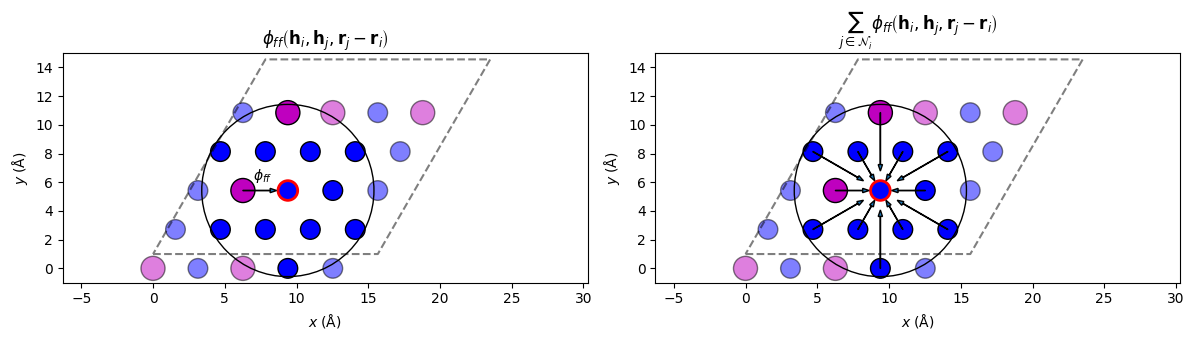

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(12,3.5))

i = 12
nbrs = [7, 8, 11, 13, 16, 17]
nbrs += [3, 6, 9, 15, 18, 21]

color = np.array(["b", "m"])[(z == 1).astype(int)]
size = np.array([200, 300])[(z == 1).astype(int)]

alpha = 0.5 * np.ones(len(atoms))
alpha[nbrs] = 1
alpha[i] = 1

# alpha = np.arange(len(x)).in(nbrs)

for ax in axes[:2]:
    ax.scatter(r1, r2, s=size, edgecolors="k", alpha=alpha, color=color)
    ax.scatter(r1[i], r2[i], s=200, edgecolors="r", color="none", linewidth=2)
    fcut = plt.Circle((r1[i], r2[i]), 6, edgecolor="k", facecolor="none")
    ax.add_patch(fcut)

    draw_cell(atoms, ax)

    ax.axis("equal")
    ax.set(xlim=(-1, 25), ylim=(-1, 15))

f = 0.75
ax = axes[0]
ax.arrow(
    r1[i-1], r2[i-1], f*(r1[i]-r1[i-1]), f*(r2[i]-r2[i-1]), 
    width=0.025, head_width=0.3, length_includes_head=True
)
ax.annotate(r"$\phi_{ff}$", xy=(r1[i-1]+0.7, r2[i-1]+0.7))
ax.set_title(r"$\phi_{ff}\left(\mathbf{h}_i, \mathbf{h}_j, \mathbf{r}_j - \mathbf{r}_i\right)$")


ax = axes[1]
ax.set_title(r"$\sum_{j \in \mathcal{N}_i} \phi_{ff}\left( \mathbf{h}_i, \mathbf{h}_j, \mathbf{r}_j - \mathbf{r}_i \right)$")


for nbr in nbrs:
    ax.arrow(
        r1[nbr], r2[nbr], f*(r1[i]-r1[nbr]), f*(r2[i]-r2[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True
    )

# ax = axes[-1]
# rs = np.linspace(1, 2.5, 100)
# ax.plot(rs, lj_energy(rs))
# ax.set(xlabel=r"$r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$", ylabel=r"$\phi_{LJ}{(r)$")


plt.tight_layout()

#### unpacking things: basis functions

For example, Gaussian radial basis functions

$$b_k(\mathbf{r}_j - \mathbf{r}_i) = b(r) = \exp \left( \frac{-(r - c_k)^2}{\sigma} \right) $$


where $\mathbf{c}$ is a vector of basis function centers and $\sigma$ is a characteristic length scale hyperparameter.


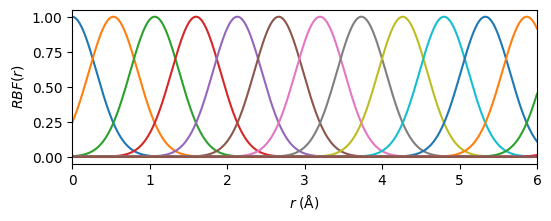

In [38]:
fig, ax = plt.subplots(figsize=(6,2))
xs = torch.linspace(0, 6, 1000)
centers = torch.linspace(0, 8, 16)

def rbf(xs, centers=centers):
    return torch.exp(-(xs[:,None] - centers)**2 / 0.2)

plt.plot(xs, rbf(xs))
plt.xlim(0,6)
plt.xlabel(r"$r \; (\mathrm{\AA})$")
plt.ylabel(r"$RBF(r)$");

# Spatial filter functions

Multiplication with a learnable weight matrix yields flexible, smooth, learnable spatial functions. This is how many ML force fields parameterize learnable spatial "filter" functions.

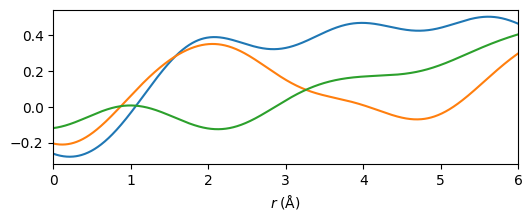

In [39]:
fig, ax = plt.subplots(figsize=(6,2))
rs = torch.linspace(0, 6, 1000)

spatial_basis_size = 16
centers = torch.linspace(0, 8, spatial_basis_size)

n_channels = 3

def rbf(xs, centers=centers):
    return torch.exp(-(xs[:,None] - centers)**2 / 0.9)

W = torch.nn.Linear(16, n_channels)

with torch.no_grad():
    plt.plot(rs, W(rbf(xs)))

plt.xlabel(r"$r \; (\mathrm{\AA})$")
plt.xlim(0, 6);

The SchNet model combines these smooth spatial functions with an elementwise product with the neighbor atom features:

$$ x_i \leftarrow \sum_{j \in \mathcal{N}(i)} W\beta(r_{ij}) \otimes x_j $$

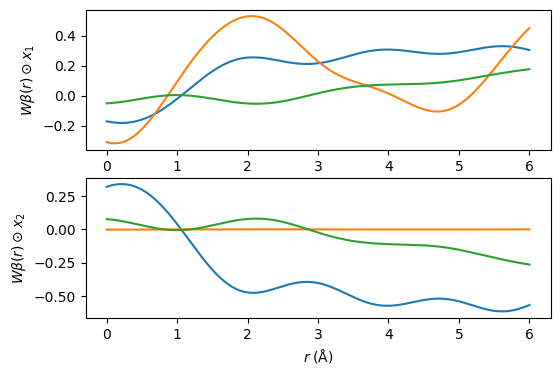

In [40]:
fig, ax = plt.subplots(nrows=2, figsize=(6,4))

# two random atom embeddings
x_j = torch.randn((2, n_channels))

with torch.no_grad():
    filter_value = W(rbf(rs))

    # broadcast update over spatial dimension (rs)
    update = filter_value.unsqueeze(0) * x_j.unsqueeze(1)
    
    ax[0].plot(rs, update[0], linestyle="-")
    ax[1].plot(rs, update[1], linestyle="-")

ax[0].set_ylabel(r"$W\beta(r) \odot x_1$")
ax[1].set_ylabel(r"$W\beta(r) \odot x_2$")
plt.xlabel(r"$r \; (\mathrm{\AA})$");

#### Feedforward model:
 and $\phi_{ffn}$ is a feedforward neural network:


In [41]:
class SimpleGraphConv(torch.nn.Module):
    def __init__(self, in_features=2, edge_features=16, out_features=8):
        super().__init__()
        d_input = 2 * in_features + edge_features

        self.project_in = torch.nn.Linear(in_features, out_features)
        self.project_spatial = torch.nn.Linear(edge_features, out_features)

    def forward(self, g: dgl.DGLGraph, x: torch.Tensor, spatial_basis: torch.Tensor):
        with g.local_scope():

            x_i = self.project_in(x)
            W = self.project_spatial(spatial_basis)

            g.ndata["x"] = x_i
            g.edata["W"] = W
            g.update_all(fn.u_mul_e("x", "W", "m_ij"), fn.sum("m_ij", "x"))
            x = g.ndata.pop("x")

        return x


in_features = 2
out_features = 6
atom_embedding = torch.nn.Embedding(2, embedding_dim=in_features)
f_gcn = SimpleGraphConv(
    in_features=in_features, edge_features=spatial_basis_size, out_features=out_features
)
g = radius_graph(atoms)

# initial node features
x = atom_embedding(g.ndata["numbers"])

# expand bond length basis functions
spatial_basis = rbf(g.edata["r_ij"].norm(dim=1))

f_gcn(g, x, spatial_basis)[:10]

tensor([[ 0.7352, -0.6669,  1.3118, -0.5255, -0.4609, -0.3195],
        [ 0.8622, -1.4392,  1.1770, -0.5018, -0.4478,  0.4178],
        [ 0.8508, -0.8134,  1.2887, -0.6359, -0.2308, -0.3655],
        [ 0.7448, -0.8986,  1.3324, -0.5089, -0.5341, -0.0554],
        [ 0.7826, -0.8980,  1.3079, -0.5210, -0.6093, -0.0494],
        [ 0.8490, -0.7350,  1.2649, -0.5486, -0.1034, -0.2602],
        [ 0.8993, -0.9008,  1.2710, -0.5534, -0.2769, -0.0588],
        [ 0.5884, -0.9243,  1.3680, -0.5138, -0.8945, -0.1479],
        [ 0.8589, -0.4718,  1.3169, -0.5662,  0.0163, -0.5273],
        [ 0.4347, -0.6837,  1.4642, -0.5357, -1.1428, -0.4112]],
       grad_fn=<SliceBackward0>)

In [42]:
# stack multiple modules

class SimpleGraphConvNet(torch.nn.Module):
    def __init__(self, in_features=2, edge_features=16, d_model=8, out_features=1):
        super().__init__()

        self.gcn_layers = torch.nn.ModuleList(
            [
                SimpleGraphConv(in_features, edge_features, d_model),
                SimpleGraphConv(d_model, edge_features, d_model),
                SimpleGraphConv(d_model, edge_features, out_features)
            ]
        )

    def forward(self, g: dgl.DGLGraph):

        # initial node features
        x = atom_embedding(g.ndata["numbers"])

        # expand  bond length basis functions
        spatial_basis = rbf(g.edata["r_ij"].norm(dim=1))
        
        # apply all interaction layers
        for layer in self.gcn_layers:
            x = layer(g, x, spatial_basis)

        # global sum pooling
        output = x.sum()

        return output
    
gcn_model = SimpleGraphConvNet(in_features=2, edge_features=16, d_model=32, out_features=1)

g = radius_graph(atoms)
gcn_model(g)

tensor(-4.9932, grad_fn=<SumBackward0>)